# Taylor integration of the Kepler problem

Here, we try to reproduce __exactly__ the [Kepler problem integration](http://nbviewer.jupyter.org/github/JuliaDiff/TaylorSeries.jl/blob/master/examples/1-KeplerProblem.ipynb) made by Luis Benet using [JuliaDiff/TaylorSeries.jl](https://github.com/JuliaDiff/TaylorSeries.jl).

In cartesian coordinates over the orbital plane, the Hamiltonian for the Kepler problem reads:

$$
H_{\mathrm{Kepler}}=\frac{1}{2\mu}(p_x^2+p_y^2)-\frac{\mu}{\sqrt{x^2+y^2}}
$$

where $\mu=G(m_1+m_2)$, $G$ is the gravitational constant, $m_1$ is the mass of the primary body and $m_2$ is the mass of the secondary body. Using Hamilton equations, we obtain the equations of motion for the Kepler problem:

$$
\begin{align}
\dot x &= p_x \\
\dot y &= p_y \\
\dot p_x &= -\frac{\mu x}{(x^2+y^2)^{3/2}}\\
\dot p_y &= -\frac{\mu y}{(x^2+y^2)^{3/2}}\\
\\
\end{align}
$$


We start by including all relevant packages:

In [1]:
using TaylorSeries
using TaylorIntegration
using PyPlot
using FastAnonymous

Some parameters necessary for the integration:

+ $\mu$: the gravitational parameter
+ `q0`: the initial state
+ `order`: the order of the Taylor expansion
+ `t_max`: the final time of the integration
+ `abs_tol`: the absolute tolerance
+ `n_iter`: the number of time-steps

In [7]:
const μ = 1.0
const q0 = [0.19999999999999996, 0.0, 0.0, 3.0] # initial condition
const order = 28
const t0 = 0.0
const t_max = 10000*(2π) # we are just taking a wild guess about the period ;)
const abs_tol = 1.0E-20
const n_iter = 10

10

As usual, we write down the equations of motion in a `function`. `q` represents the system state, with the first component being the current value of the independent variable. Hence, its evolution is given by $\dot t = 1$. `params` represents the parameters of a given system of differential equations. In the Kepler problem case, the only parameter is $\mu$, the mass parameter.

In [8]:
function kepler_problem{T<:Number}(q::Array{Taylor1{T},1})
    r_p3d2 = (q[1]^2+q[2]^2)^(3/2)
    
    q[3],
    q[4],
    -μ*q[1]/r_p3d2,
    -μ*q[2]/r_p3d2
end

kepler_problem (generic function with 1 method)

`FastAnonymous` versions of `kepler_problem` and `stepsizeall_anon`:

In [9]:
kepler_anon = @anon q__ -> kepler_problem(q__)

(q__) -> quote  # In[9], line 1:
    Main.kepler_problem(q__)
end

In [10]:
stepsizeall_anon = @anon (q, epsilon)->stepsizeall(q, epsilon)

(q,epsilon) -> quote  # In[10], line 1:
    Main.stepsizeall(q,epsilon)
end

The `Array` of `Array`s `q` will store the history of states of the system during each time-step:

In [11]:
q = Array{Float64,1}[]

t = Float64[]; push!(q, t)
x = Float64[]; push!(q, x)
y = Float64[]; push!(q, y)
px = Float64[]; push!(q, px)
py = Float64[]; push!(q, py)

5-element Array{Array{Float64,1},1}:
 Float64[]
 Float64[]
 Float64[]
 Float64[]
 Float64[]

The Taylor integration:

In [13]:
@time integrate!(kepler_anon, stepsizeall_anon, q0, abs_tol, order, t0, t_max, q)

 39.931903 seconds (426.85 M allocations: 35.975 GB, 9.84% gc time)


4-element Array{Float64,1}:
  0.199853 
  0.0102879
 -0.085682 
  2.9978   

The final state:

In [14]:
t[end], x[end], y[end], px[end], py[end]

(62831.85650193086,0.19985298833903653,0.010287886829271349,-0.08568200522828756,2.9977961210694137)

The number of time steps is equal to the `length` of vector `t` minus 1:

In [15]:
length(t)-1

436152

A `FastAnonymous` version of the Hamiltonian:

In [16]:
H = @anon (x, y, px, py) -> 0.5*(px*px+py*py)-μ/sqrt(x*x+y*y)

(x,y,px,py) -> quote  # In[16], line 1:
    Main.-(Main.*(0.5,Main.+(Main.*(px,px),Main.*(py,py))),Main./(μ,Main.sqrt(Main.+(Main.*(x,x),Main.*(y,y)))))
end
with:
  μ: 1.0

The energy during each time-step:

In [17]:
E = map(H, x, y, px, py);

The initial energy:

In [18]:
E0=E[1]

-0.5000000000000009

The relative error in the energy is $\delta E$:

In [19]:
δE = (E-E0)/(E0);

A $\delta E$ vs $t$ plot:

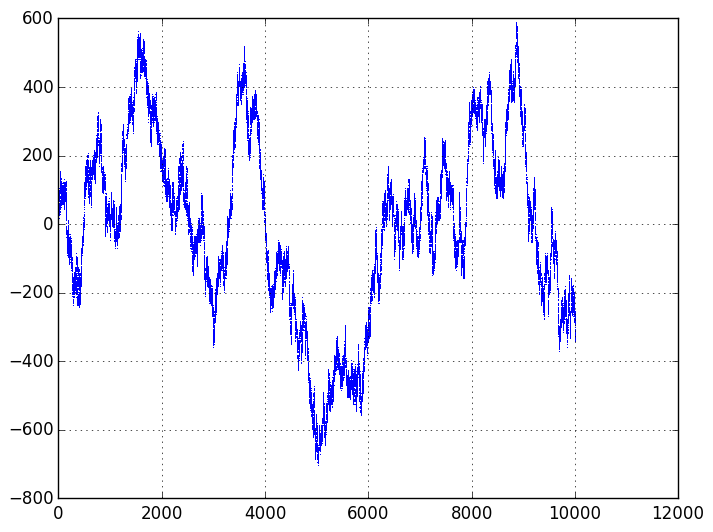

In [20]:
grid(true)
plot(t/(2π), δE/eps(Float64), ",");

How does the energy error distribute around zero?

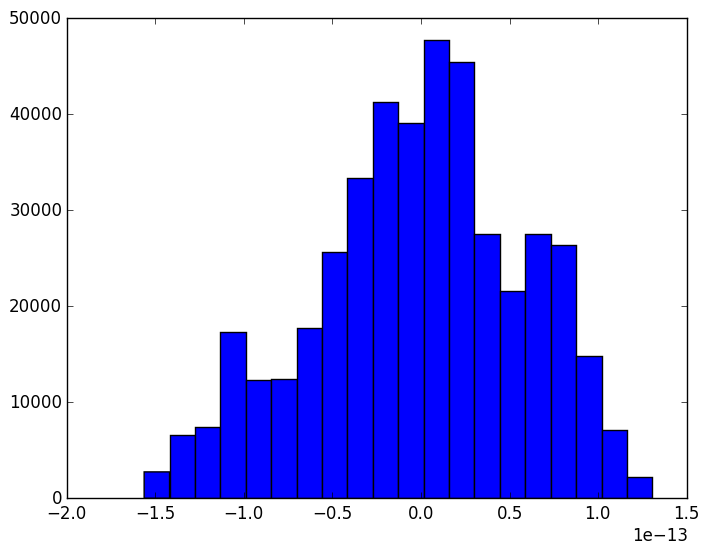

In [21]:
h = plt[:hist](δE, 20);

A `FastAnonymous` version of the angular momentum:

In [22]:
L_anon = @anon (x, y, px, py) -> x*py-y*px

(x,y,px,py) -> quote  # In[22], line 1:
    Main.-(Main.*(x,py),Main.*(y,px))
end

The angular momentum during each time-step:

In [23]:
L = map(L_anon, x, y, px, py);

The initial angular momentum:

In [24]:
L0 = L[1]

0.5999999999999999

The relative error in the angular momentum during the integration is $\delta L$:

In [25]:
δL = (L-L0)/L0;

A $\delta L$ vs $t$ plot:

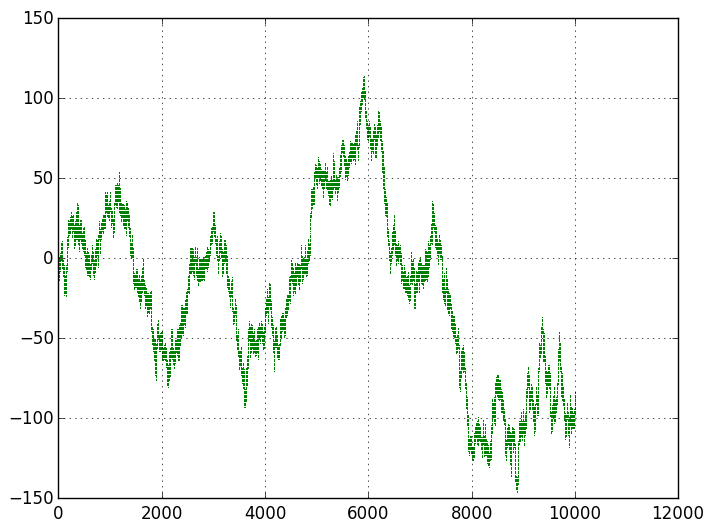

In [26]:
grid(true)
plot(t/(2π), δL/eps(Float64), "g,");

What is the distribution of the angular momentum relative error?

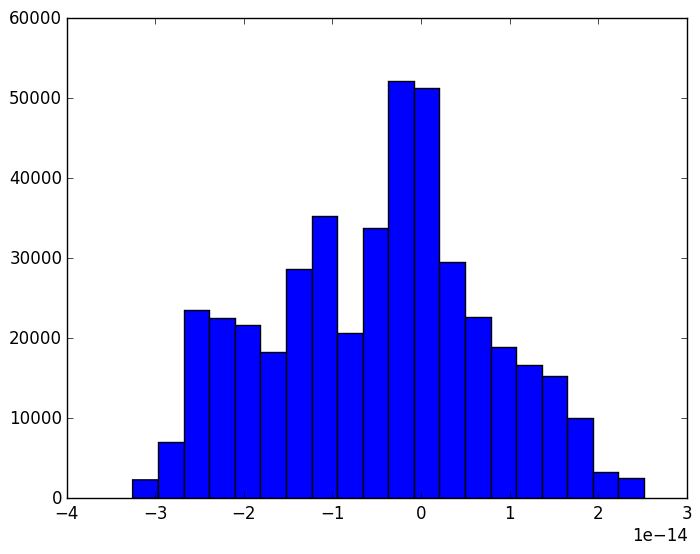

In [27]:
h = plt[:hist]( δL, 20 );

A $\delta E$, $\delta L$ plot vs $t$:

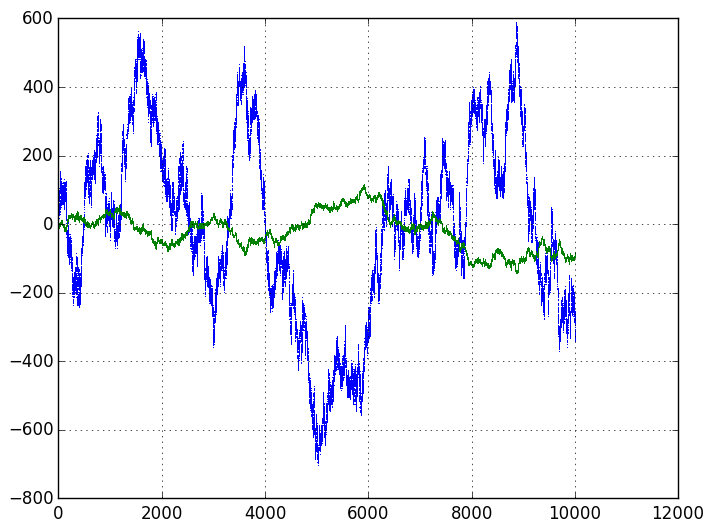

In [28]:
grid(true)
plot(t/(2π), δE/eps(Float64), "b,", t/(2π), δL/eps(Float64), "g,");